In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import shutil, os, pathlib
print(tf.__version__)

2024-07-28 22:09:15.483731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 22:09:15.496761: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 22:09:15.574107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 22:09:15.647153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 22:09:15.709259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

2.17.0


In [2]:
new_base_dir = pathlib.Path("data/dogs-vs-cats/small")
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=(180, 180), batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=(180, 180), batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=(180, 180), batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
class ModelForVGGFeatures(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv_base = tf.keras.applications.vgg16.VGG16(
            weights="imagenet", include_top=False, input_shape=(180, 180, 3)
        )
        self.conv_base.trainable = False

        self.data_augmentation = tf.keras.Sequential(
            [
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.2),
            ]
        )

        self.layers_list = []
        self.layers_list.append(tf.keras.layers.Flatten())
        self.layers_list.append(tf.keras.layers.Dense(256, activation="relu"))
        self.layers_list.append(tf.keras.layers.Dropout(0.5))
        self.layers_list.append(tf.keras.layers.Dense(1, activation="sigmoid"))

    def call(self, inputs):
        z = inputs
        z = self.data_augmentation(z)
        z = tf.keras.applications.vgg16.preprocess_input(z)
        z = self.conv_base(z)
        for layer in self.layers_list:
            z = layer(z)
        return z


model = ModelForVGGFeatures()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
# print(model.summary())

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="data/model_checkpoints/vgg-features-with-augmentation-dogscats.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.8103 - loss: 12.2712 - val_accuracy: 0.9350 - val_loss: 0.6341
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.9305 - loss: 0.6455 - val_accuracy: 0.9370 - val_loss: 0.3593
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.9375 - loss: 0.4401 - val_accuracy: 0.9500 - val_loss: 0.2566
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.9543 - loss: 0.2938 - val_accuracy: 0.9390 - val_loss: 0.4250
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.9622 - loss: 0.2524 - val_accuracy: 0.9460 - val_loss: 0.4930
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.9610 - loss: 0.3128 - val_accuracy: 0.9460 - val_loss: 0.4432
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9558 - loss: 0.3313 - val_accuracy: 0.9540 - val_loss: 0.3029
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.9749 - loss: 0.1880 - val_accuracy: 0.9500 - 

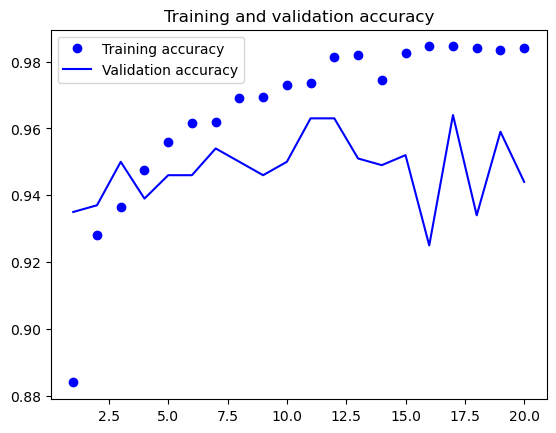

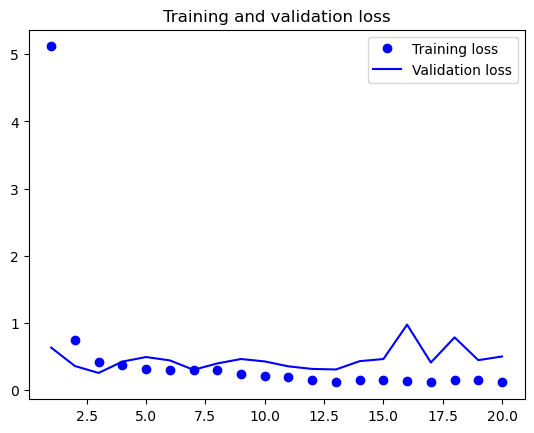

In [6]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()